# Jupyter notebook to plot compare petrological rock catalogue and regional joint inversion


This notebook plot extract the inverted density and susceptibility values from the regional joint inversion and compares to the meassured density and susceptibility from northern Victoria Land rock samples.

#### jupyter notebook written by Maximilian Lowe (maxwe32@bas.ac.uk). Last update 15/02/2024

In [1]:
import numpy as np
import netCDF4 as nc4
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import os
import pandas as pd
import geopandas as gpd
from cmcrameri import cm
import cartopy.crs as ccrs
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from scipy.interpolate import griddata

In [2]:
export_fig_path = "VI_regional_inversion_reg10_coupling_15e3_run2/Figure/"

# Create path if it does not exists
if not os.path.exists(export_fig_path):
    os.makedirs(export_fig_path)

In [3]:
shift_values_pd = pd.read_csv(
    "VI_regional_inversion_reg10_coupling_15e3_run2/DATA/exported_shift_value.txt",
    skiprows=1,
    names=["x_shift", "y_shift"],
)
shift_values = shift_values_pd.to_numpy()


study_area_pd = pd.read_csv(
    "VI_regional_inversion_reg10_coupling_15e3_run2/DATA/study_padding_area.txt",
    skiprows=1,
    names=["x_stu", "y_stu", "x_pad", "y_pad"],
)
study_area = study_area_pd.to_numpy()


study_area_geom = Polygon(zip(study_area[:, 0], study_area[:, 1]))
study_area_polygon = gpd.GeoDataFrame(
    index=[0], crs="epsg:3031", geometry=[study_area_geom]
)

filename = "DATA/GeoMap_Coastline_df.geojson"
file = open(filename)
Coastline = gpd.read_file(file)

filename = "DATA/GeoMap_GHI_df.geojson"
file = open(filename)
GHI_wsb = gpd.read_file(file)

In [4]:
# read in magnetic inversion model
mag_fh = Dataset(
    "VI_regional_inversion_reg10_coupling_15e3_run2/VI_inversion/result.mag.inv.nc"
)
X_sus = mag_fh.variables["Northing"][:] - (shift_values[0, 0] * 2)
Y_sus = mag_fh.variables["Easting"][:] - (shift_values[0, 1] * 2)
Depth_sus = mag_fh.variables["Depth"][:]
X_sus_Origin = mag_fh.variables["Northing_Origin"][:] - (shift_values[0, 0] * 2)
Y_sus_Origin = mag_fh.variables["Easting_Origin"][:] - (shift_values[0, 1] * 2)
Depth_sus_Origin = mag_fh.variables["Depth_Origin"][:]
inv_sus = mag_fh.variables["Susceptibility"][:, :, :]
mag_fh.close()

# and the corresponding gravity model, do not need geometry as we know it is the same
grav_fh = Dataset(
    "VI_regional_inversion_reg10_coupling_15e3_run2/VI_inversion/result.grav.inv.nc"
)
inv_dens = grav_fh.variables["Density"][:, :, :]
grav_fh.close()

In [5]:
xx, yy = np.meshgrid(X_sus, Y_sus)
Depth_inversion_km = np.round((Depth_sus / 1000), 1)
print(Depth_inversion_km)

[-3.0 -1.9 -0.7 0.6 2.1 3.7 5.5 7.4 9.6 11.9 14.5 17.4 20.5 24.0 27.8 32.0
 36.5 41.6 47.2 53.3 60.0]


In [6]:
Depth_inversion_km

masked_array(data=[-3.0, -1.9, -0.7, 0.6, 2.1, 3.7, 5.5, 7.4, 9.6, 11.9,
                   14.5, 17.4, 20.5, 24.0, 27.8, 32.0, 36.5, 41.6, 47.2,
                   53.3, 60.0],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False],
       fill_value=1e+20)

In [7]:
x = np.arange(min(X_sus), max(X_sus), 1000)  # 1000 m grid cize (1 km)
y = np.arange(min(Y_sus), max(Y_sus), 1000)  # 1000 m grid cize (1 km)

xq, yq = np.meshgrid(x, y)


point = np.vstack((xx.flatten(), yy.flatten())).T
value_dens = inv_dens[4, :, :].flatten()
value_sus = inv_sus[4, :, :].flatten()

grid_dens = griddata(point, value_dens, (xq, yq), method="linear")
grid_sus = griddata(point, value_sus, (xq, yq), method="linear")


inv_dens_sus_d = {
    "Xps": xq.flatten(),
    "Yps": yq.flatten(),
    "inv_dens": grid_dens.flatten(),
    "inv_sus": grid_sus.flatten(),
}
inv_dens_sus_df = pd.DataFrame(data=inv_dens_sus_d)
inv_dens_sus_gdf = gpd.GeoDataFrame(
    inv_dens_sus_df,
    geometry=gpd.points_from_xy(inv_dens_sus_df.Xps, inv_dens_sus_df.Yps),
    crs="EPSG:3031",
)
inv_dens_sus_gdf

,Xps,Yps,inv_dens,inv_sus,geometry
0,2.750000e+04,-2.296430e+06,0.000000,0.000000,POINT (27500.000 -2296429.703)
1,2.850000e+04,-2.296430e+06,0.000000,0.000000,POINT (28500.000 -2296429.703)
2,2.950000e+04,-2.296430e+06,0.000000,0.000000,POINT (29500.000 -2296429.703)
3,3.050000e+04,-2.296430e+06,0.000000,0.000000,POINT (30500.000 -2296429.703)
4,3.150000e+04,-2.296430e+06,0.000000,0.000000,POINT (31500.000 -2296429.703)
...,...,...,...,...,...
1901384,1.845500e+06,-1.254430e+06,-2.953744,-0.001497,POINT (1845500.000 -1254429.703)
1901385,1.846500e+06,-1.254430e+06,-2.953739,-0.001497,POINT (1846500.000 -1254429.703)
1901386,1.847500e+06,-1.254430e+06,-2.953734,-0.001497,POINT (1847500.000 -1254429.703)
1901387,1.848500e+06,-1.254430e+06,-2.953728,-0.001497,POINT (1848500.000 -1254429.703)


In [8]:
inv_dens_sus_cliped_GHI_gpd = gpd.clip(inv_dens_sus_gdf, GHI_wsb)
inv_dens_sus_cliped_GHI_gpd.shape

(1415, 5)

In [9]:
# create WSB polygon
x_ps_MessaRange_point_list = [
    507404.438756447,
    569404.438756447,
    569404.438756447,
    507404.438756447,
    507404.438756447,
]
y_ps_MessaRange_point_list = [
    -1773582.79591434,
    -1773582.79591434,
    -1699582.79591434,
    -1699582.79591434,
    -1773582.79591434,
]

polygon_geom_MessaRange = Polygon(
    zip(x_ps_MessaRange_point_list, y_ps_MessaRange_point_list)
)
polygon_MessaRange = gpd.GeoDataFrame(
    index=[0], crs="epsg:3031", geometry=[polygon_geom_MessaRange]
)

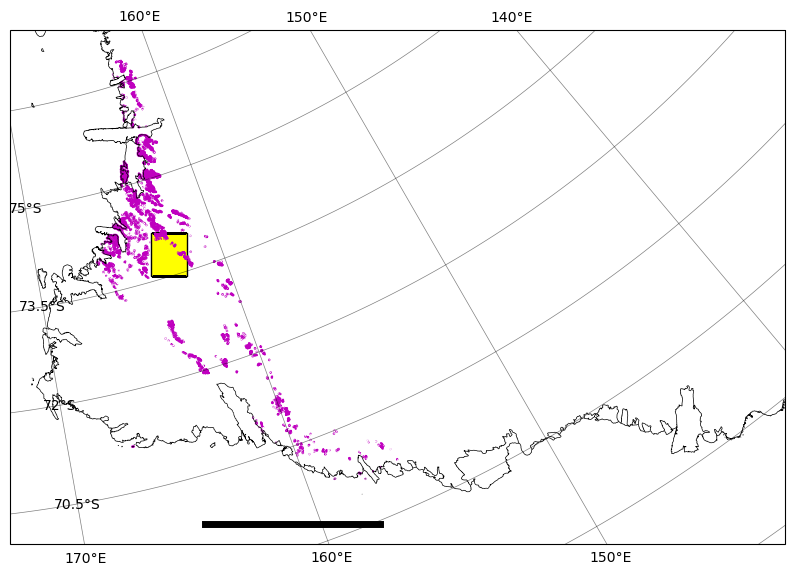

In [10]:
cmap_rev = cm.roma_r.resampled(20)

inv_dens_depth_slice = inv_dens[4, :, :]
inv_sus_depth_slice = inv_sus[4, :, :]

figure1 = plt.figure(figsize=(10, 8), facecolor="white")

ax1 = plt.subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())
# im1 = plt.pcolormesh(xq , yq ,grid_sus , cmap = cmap_rev)
GHI_wsb.boundary.plot(ax=ax1, color="m", alpha=1, label="Granite Harbour Intrusives")
polygon_MessaRange.plot(ax=ax1, alpha=1, facecolor="yellow", edgecolor="k")


Coastline.plot(ax=ax1, color="k", linewidth=0.5)
ax1.gridlines(
    linewidth=0.5,
    draw_labels=True,
    color="k",
    alpha=0.5,
    linestyle="-",
    rotate_labels=0,
)
ax1.set_extent([172, 135, -73, -70], ccrs.PlateCarree())
axes = plt.gca()

# cb = plt.colorbar(im1, shrink=1)
# cb.ax.set_title('[SI]',fontsize=10)
# ax1.plot(study_area[:,0] , study_area[:,1] , 'k-' , label='VI inversion extent')
ax1.plot(
    [0.6e6, 0.6e6 + 300000], [-2.2e6, -2.2e6], "-k", linewidth=5
)  # 300 km scale bar
# ax1.legend(loc='lower right')
plt.savefig(
    export_fig_path + "Geomap_polgygons_GHI.png",
    facecolor=figure1.get_facecolor(),
    transparent=True,
)

In [11]:
NAPA_measurments_df = pd.read_csv(
    "Petrological_data/Density_and_susceptibility_rock_sample_catalogue_northern_Victoria_Land_East_Antarctica.csv"
)

NAPA_measurments_df["susceptibility 1 [10-3 SI]"] = (
    NAPA_measurments_df["susceptibility 1 [10-3 SI]"] * 1e-3
)
NAPA_measurments_df["susceptibility 2 [10-3 SI]"] = (
    NAPA_measurments_df["susceptibility 2 [10-3 SI]"] * 1e-3
)
NAPA_measurments_df["susceptibility 3 [10-3 SI]"] = (
    NAPA_measurments_df["susceptibility 3 [10-3 SI]"] * 1e-3
)
NAPA_measurments_df["susceptibility 4 [10-3 SI]"] = (
    NAPA_measurments_df["susceptibility 4 [10-3 SI]"] * 1e-3
)
NAPA_measurments_df["susceptibility 5 [10-3 SI]"] = (
    NAPA_measurments_df["susceptibility 5 [10-3 SI]"] * 1e-3
)
NAPA_measurments_df["susceptibility 6 [10-3 SI]"] = (
    NAPA_measurments_df["susceptibility 6 [10-3 SI]"] * 1e-3
)
NAPA_measurments_df["susceptibility 7 [10-3 SI]"] = (
    NAPA_measurments_df["susceptibility 7 [10-3 SI]"] * 1e-3
)
NAPA_measurments_df["susceptibility 8 [10-3 SI]"] = (
    NAPA_measurments_df["susceptibility 8 [10-3 SI]"] * 1e-3
)
NAPA_measurments_df["susceptibility average [10-3 SI]"] = (
    NAPA_measurments_df["susceptibility average [10-3 SI]"] * 1e-3
)
NAPA_measurments_df["susceptibility std [10-3 SI]"] = (
    NAPA_measurments_df["susceptibility std [10-3 SI]"] * 1e-3
)

In [12]:
NAPA_GHI_df = NAPA_measurments_df[
    (NAPA_measurments_df["stratigraphy"] == "Granite Harbour Intrusives")
]


NAPA_GHI_density_mean = np.mean(NAPA_GHI_df["density [g/cm^3]"])
NAPA_GHI_density_std = np.std(NAPA_GHI_df["density [g/cm^3]"])
NAPA_GHI_sus_mean = np.mean(NAPA_GHI_df["susceptibility average [10-3 SI]"])
NAPA_GHI_sus_std = np.std(NAPA_GHI_df["susceptibility average [10-3 SI]"])

## convert lon lat to decimal
longitude_pd = NAPA_GHI_df["longitude"]
latitude_pd = NAPA_GHI_df["latitude"]

longitude = longitude_pd.to_numpy()
latitude = latitude_pd.to_numpy()

lon_decimal = np.zeros((len(NAPA_GHI_df), 1))
lat_decimal = np.zeros((len(NAPA_GHI_df), 1))

for i in range(len(NAPA_GHI_df)):
    if pd.isna(latitude[i]) != True:
        lon_deg = float(longitude[i][0:3])
        lon_min = float(longitude[i][5:7])
        lon_ix = lon_deg + ((lon_min) / 60)
        lon_decimal[i] = lon_ix

        lat_deg = float(latitude[i][0:2])
        lat_min = float(latitude[i][4:6])
        lat_ix = (
            lat_deg + ((lat_min) / 60)
        ) * -1  # south needs minus for maps plotting
        lat_decimal[i] = lat_ix
NAPA_GHI_df = NAPA_GHI_df.assign(longitude_deg=lon_decimal)
NAPA_GHI_df = NAPA_GHI_df.assign(latitude_deg=lat_decimal)

## create geopanda dataframe
NAPA_GHI_gpdf = gpd.GeoDataFrame(
    NAPA_GHI_df,
    geometry=gpd.points_from_xy(NAPA_GHI_df.longitude_deg, NAPA_GHI_df.latitude_deg),
    crs="EPSG:4326",
)

## reproject geopanda dataframe to sterographic coordinates
NAPA_GHI_ps_gpdf = NAPA_GHI_gpdf.to_crs(3031)

In [13]:
NAPA_GHI_ps_gpdf["density [g/cm^3]"] = NAPA_GHI_ps_gpdf["density [g/cm^3]"] * 1000

dens_shifted = inv_dens_sus_cliped_GHI_gpd["inv_dens"] + 2670
sus_shifted = inv_dens_sus_cliped_GHI_gpd["inv_sus"] + 0.008

inv_dens_sus_cliped_GHI_gpd["dens_shifted"] = dens_shifted
inv_dens_sus_cliped_GHI_gpd["sus_shifted"] = sus_shifted

C:\Users\maxim\.conda\envs\JIF3D\lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\maxim\.conda\envs\JIF3D\lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [14]:
NAPA_Granite_Harbour_Intrusives_density_mean = np.mean(
    NAPA_GHI_ps_gpdf["density [g/cm^3]"]
)
NAPA_Granite_Harbour_Intrusives_density_std = np.std(
    NAPA_GHI_ps_gpdf["density [g/cm^3]"]
)
NAPA_Granite_Harbour_Intrusives_sus_mean = np.mean(
    NAPA_GHI_ps_gpdf["susceptibility average [10-3 SI]"]
)
NAPA_Granite_Harbour_Intrusives_sus_std = np.std(
    NAPA_GHI_ps_gpdf["susceptibility average [10-3 SI]"]
)


inv_density_mean = np.mean(inv_dens_sus_cliped_GHI_gpd["dens_shifted"])
inv_density_std = np.std(inv_dens_sus_cliped_GHI_gpd["dens_shifted"])
inv_sus_mean = np.mean(inv_dens_sus_cliped_GHI_gpd["sus_shifted"])
inv_sus_std = np.std(inv_dens_sus_cliped_GHI_gpd["sus_shifted"])

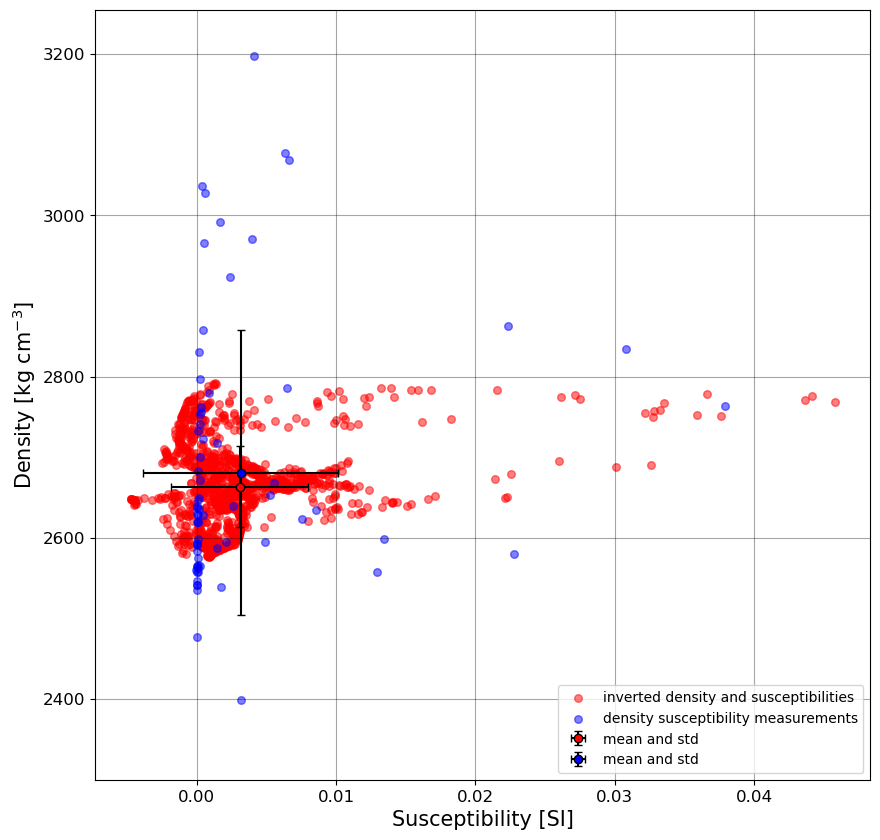

In [15]:
figure2 = plt.figure(figsize=(10, 10), facecolor="white")
ax1 = plt.subplot(1, 1, 1)

inv_dens_sus_cliped_GHI_gpd.plot(
    kind="scatter",
    ax=ax1,
    x="sus_shifted",
    y="dens_shifted",
    marker="o",
    s=30,
    c="red",
    alpha=0.5,
    label="inverted density and susceptibilities",
)

plt.errorbar(
    inv_sus_mean,
    inv_density_mean,
    xerr=inv_sus_std,
    yerr=inv_density_std,
    fmt="ko",
    markersize=6,
    markerfacecolor="red",
    markeredgecolor="k",
    capsize=3,
    label="mean and std",
)


NAPA_GHI_ps_gpdf.plot(
    kind="scatter",
    ax=ax1,
    x="susceptibility average [10-3 SI]",
    y="density [g/cm^3]",
    marker="o",
    s=30,
    c="blue",
    alpha=0.5,
    label="density susceptibility measurements",
)

plt.errorbar(
    NAPA_Granite_Harbour_Intrusives_sus_mean,
    NAPA_Granite_Harbour_Intrusives_density_mean,
    xerr=NAPA_Granite_Harbour_Intrusives_sus_std,
    yerr=NAPA_Granite_Harbour_Intrusives_density_std,
    fmt="ko",
    markersize=6,
    markerfacecolor="blue",
    markeredgecolor="k",
    capsize=3,
    label="mean and std",
)


ax1.grid(visible=True, which="major", color="k", linestyle="-", alpha=0.35)
ax1.set_xlabel("Susceptibility [SI]", fontsize=15)
ax1.set_ylabel("Density [kg cm$^{-3}$]", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().set_ylim(bottom=2300)
plt.legend(loc="lower right")
# plt.title("Granite Harbour Intrusives petrological relationship")
plt.savefig(
    export_fig_path + "dens_sus_GHI_and_filtered_inv.png",
    facecolor=figure1.get_facecolor(),
    transparent=True,
)

In [16]:
GHI_Granit = NAPA_GHI_ps_gpdf[
    (NAPA_GHI_ps_gpdf["rocktyp"] == "Granite")
    | (NAPA_GHI_ps_gpdf["rocktyp"] == "Granite, fine-grained")
    | (NAPA_GHI_ps_gpdf["rocktyp"] == "Granite, small- to fine-grained")
    | (NAPA_GHI_ps_gpdf["rocktyp"] == "Granite, small-grained")
    | (NAPA_GHI_ps_gpdf["rocktyp"] == "Granite, medium to coarse-grained")
    | (NAPA_GHI_ps_gpdf["rocktyp"] == "Granite, medium-grained")
    | (NAPA_GHI_ps_gpdf["rocktyp"] == "Large grain-Granite")
    | (NAPA_GHI_ps_gpdf["rocktyp"] == "Granite/Orthogneiss")
    | (NAPA_GHI_ps_gpdf["rocktyp"] == "Granite-Gneiss, medium-grain")
    | (NAPA_GHI_ps_gpdf["rocktyp"] == "Granite-Mylonit")
    | (NAPA_GHI_ps_gpdf["rocktyp"] == "sc-Mylonite im Granite")
    | (NAPA_GHI_ps_gpdf["rocktyp"] == "Granite, coarse-grained")
]

GHI_Diorit = NAPA_GHI_ps_gpdf[(NAPA_GHI_ps_gpdf["rocktyp"] == "Diorit")]

GHI_Granodiorit = NAPA_GHI_ps_gpdf[(NAPA_GHI_ps_gpdf["rocktyp"] == "Granodiorit")]

GHI_Gabbro = NAPA_GHI_ps_gpdf[
    (NAPA_GHI_ps_gpdf["rocktyp"] == "Gabbro")
    | (NAPA_GHI_ps_gpdf["rocktyp"] == "Hornblende/Gabbro")
    | (NAPA_GHI_ps_gpdf["rocktyp"] == "Gabbro (Diorite?)")
]

GHI_Hornblendit = NAPA_GHI_ps_gpdf[
    (NAPA_GHI_ps_gpdf["rocktyp"] == "Hornblendit")
    | (NAPA_GHI_ps_gpdf["rocktyp"] == "Hbl-Diorit")
]

GHI_Gneis = NAPA_GHI_ps_gpdf[
    (NAPA_GHI_ps_gpdf["rocktyp"] == "Sillimanit-Biotit-Gneiss")
    | (NAPA_GHI_ps_gpdf["rocktyp"] == "Hornblende-Gneiss")
    | (NAPA_GHI_ps_gpdf["rocktyp"] == "Orthogneiss/Granitoid")
    | (NAPA_GHI_ps_gpdf["rocktyp"] == "Biotitgneiss")
    | (NAPA_GHI_ps_gpdf["rocktyp"] == "Biotit-Gneiss")
    | (NAPA_GHI_ps_gpdf["rocktyp"] == "Gneiss")
    | (NAPA_GHI_ps_gpdf["rocktyp"] == "Orthogneiss")
    | (NAPA_GHI_ps_gpdf["rocktyp"] == "Bt-Gneiss")
    | (NAPA_GHI_ps_gpdf["rocktyp"] == "Garnet-Gneiss")
    | (NAPA_GHI_ps_gpdf["rocktyp"] == "Granite-Gneiss, medium-grain")
    | (NAPA_GHI_ps_gpdf["rocktyp"] == "Gneiss")
    | (NAPA_GHI_ps_gpdf["rocktyp"] == "Sillimanitgneiss")
    | (NAPA_GHI_ps_gpdf["rocktyp"] == "Bt-Gneise")
    | (NAPA_GHI_ps_gpdf["rocktyp"] == "Sillimanite-Gneiss")
    | (NAPA_GHI_ps_gpdf["rocktyp"] == "Garnet-Gneiss")
]

GHI_Syenit = NAPA_GHI_ps_gpdf[
    (NAPA_GHI_ps_gpdf["rocktyp"] == "Syenite, medium-grain")
    | (NAPA_GHI_ps_gpdf["rocktyp"] == "Syenite")
]

GHI_Ultrabasit = NAPA_GHI_ps_gpdf[
    (NAPA_GHI_ps_gpdf["rocktyp"] == "Ultrabasit")
    | (NAPA_GHI_ps_gpdf["rocktyp"] == "Basit")
    | (NAPA_GHI_ps_gpdf["rocktyp"] == "Basit or Ultrabasit")
]

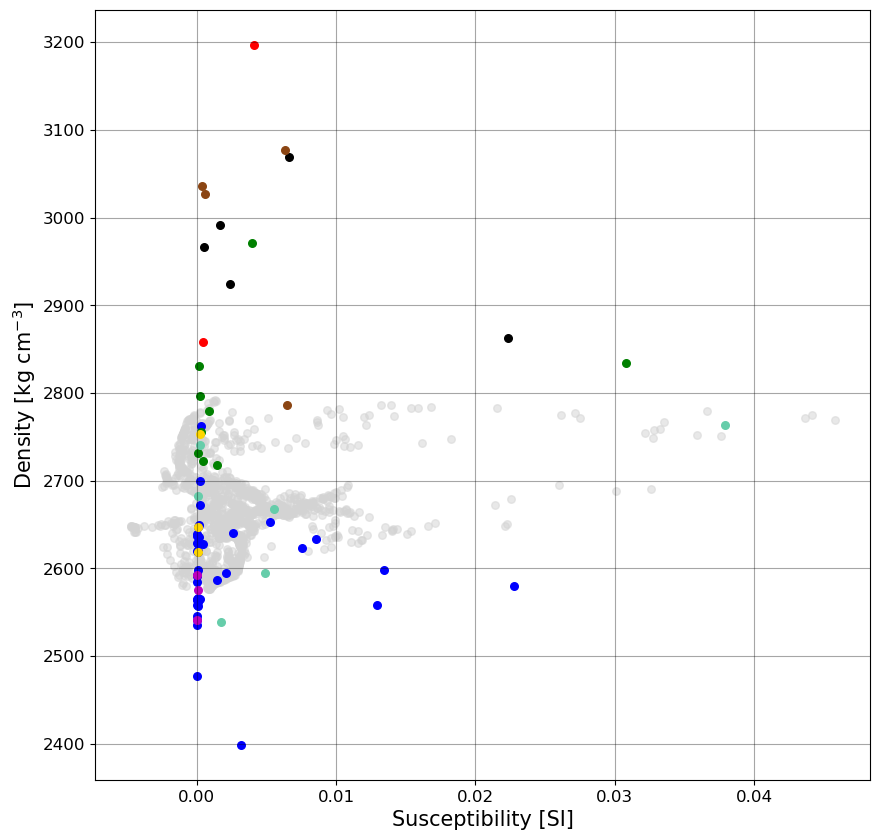

In [17]:
figure2 = plt.figure(figsize=(10, 10), facecolor="white")
ax1 = plt.subplot(1, 1, 1)

inv_dens_sus_cliped_GHI_gpd.plot(
    kind="scatter",
    ax=ax1,
    x="sus_shifted",
    y="dens_shifted",
    marker="o",
    s=30,
    c="lightgray",
    alpha=0.5,
)


GHI_Granit.plot(
    kind="scatter",
    ax=ax1,
    x="susceptibility average [10-3 SI]",
    y="density [g/cm^3]",
    marker="o",
    s=30,
    c="blue",
    alpha=1,
)

GHI_Diorit.plot(
    kind="scatter",
    ax=ax1,
    x="susceptibility average [10-3 SI]",
    y="density [g/cm^3]",
    marker="o",
    s=30,
    c="green",
    alpha=1,
)

GHI_Granodiorit.plot(
    kind="scatter",
    ax=ax1,
    x="susceptibility average [10-3 SI]",
    y="density [g/cm^3]",
    marker="o",
    s=30,
    c="mediumaquamarine",
    alpha=1,
)

GHI_Gabbro.plot(
    kind="scatter",
    ax=ax1,
    x="susceptibility average [10-3 SI]",
    y="density [g/cm^3]",
    marker="o",
    s=30,
    c="k",
    alpha=1,
)

GHI_Hornblendit.plot(
    kind="scatter",
    ax=ax1,
    x="susceptibility average [10-3 SI]",
    y="density [g/cm^3]",
    marker="o",
    s=30,
    c="r",
    alpha=1,
)

GHI_Gneis.plot(
    kind="scatter",
    ax=ax1,
    x="susceptibility average [10-3 SI]",
    y="density [g/cm^3]",
    marker="o",
    s=30,
    c="gold",
    alpha=1,
)

GHI_Syenit.plot(
    kind="scatter",
    ax=ax1,
    x="susceptibility average [10-3 SI]",
    y="density [g/cm^3]",
    marker="o",
    s=30,
    c="m",
    alpha=1,
)

GHI_Ultrabasit.plot(
    kind="scatter",
    ax=ax1,
    x="susceptibility average [10-3 SI]",
    y="density [g/cm^3]",
    marker="o",
    s=30,
    c="saddlebrown",
    alpha=1,
)

ax1.grid(visible=True, which="major", color="k", linestyle="-", alpha=0.35)
ax1.set_xlabel("Susceptibility [SI]", fontsize=15)
ax1.set_ylabel("Density [kg cm$^{-3}$]", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig(
    export_fig_path + "inv_sus_dens_and_rocktypes_within_GHI.png",
    facecolor=figure1.get_facecolor(),
    transparent=True,
)

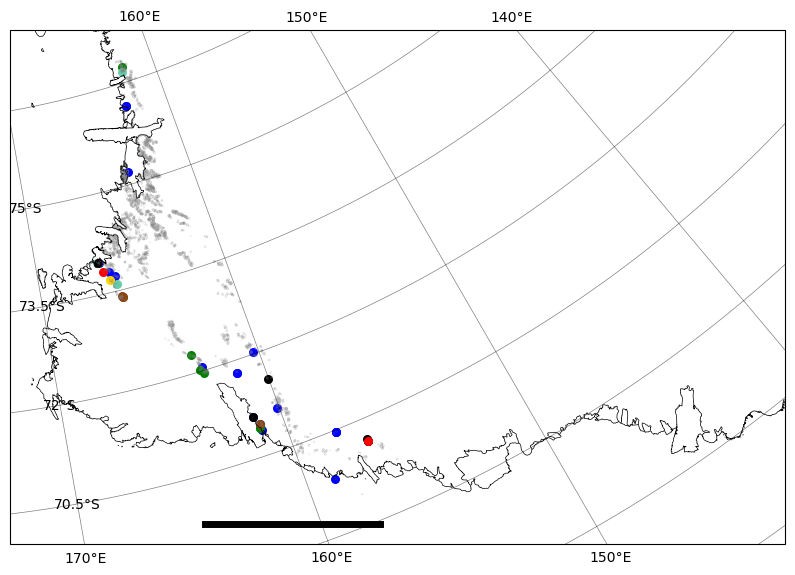

In [18]:
makersize_ix = 15

# create figure
figure1 = plt.figure(figsize=(10, 8), facecolor="white")

# subplot BA gravity data
ax1 = plt.subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())
# plt.title('Location NAPA rock samples',fontsize=25)

GHI_Granit.plot(ax=ax1, marker="o", markersize=30, c="blue", alpha=1, label="Granit")
GHI_Diorit.plot(ax=ax1, marker="o", markersize=30, c="green", alpha=1, label="Diorit")
GHI_Granodiorit.plot(
    ax=ax1,
    marker="o",
    markersize=30,
    c="mediumaquamarine",
    alpha=1,
    label="Granodiorit",
)
GHI_Gabbro.plot(ax=ax1, marker="o", markersize=30, c="k", alpha=1, label="Gabbro")
GHI_Hornblendit.plot(
    ax=ax1, marker="o", markersize=30, c="r", alpha=1, label="Hornblendit"
)
GHI_Gneis.plot(ax=ax1, marker="o", markersize=30, c="gold", alpha=1, label="Gneis")
GHI_Syenit.plot(ax=ax1, marker="o", markersize=30, c="m", alpha=1, label="Syenit")
GHI_Ultrabasit.plot(
    ax=ax1, marker="o", markersize=30, c="saddlebrown", alpha=1, label="Ultrabasit"
)

GHI_wsb.boundary.plot(
    ax=ax1, color="gray", alpha=0.3, label="Granit Habour from GeoMap"
)


ax1.set_extent([172, 135, -73, -70], ccrs.PlateCarree())
ax1.plot(
    [0.6e6, 0.6e6 + 300000], [-2.2e6, -2.2e6], "-k", linewidth=5
)  # 300 km scale bar
# ax1.legend(loc='lower right')
ax1.gridlines(
    linewidth=0.5,
    draw_labels=True,
    color="k",
    alpha=0.5,
    linestyle="-",
    rotate_labels=0,
)
Coastline.plot(ax=ax1, color="k", linewidth=0.5)
plt.savefig(
    export_fig_path + "rocktypes_within_GHI_map.png",
    facecolor=figure1.get_facecolor(),
    transparent=True,
)